In [89]:
source("../00_model-fitting/wwa_model-fitting.R")

---
# **Observational analysis**

## **fwi7x**
Annual maximum of fwi7x averaged over the JB region (can occur at any time of year)

In [74]:
# load data, fit model
df <- merge(read.csv("data/gmst.csv"), load_ts("ts/canada-wildfires_era5_fwi7x.dat", col.names = c("year", "fwi7x")))
mdl_fwi7x <- fit_ns("gev", "fixeddisp", df, "fwi7x", "gmst", lower = F)
gmst_2023 <- df$gmst[df$year == 2023]

In [90]:
# fitted model
ylim <- c(0,8)

prep_window(c(1,2))
png(paste0("fig/mfit_era5_fwi7x.png"), height = 480, width = 480 * 3); par(mfrow = c(1,2), cex = 1.4, mar = c(4,4,2,1)); {
    # par(oma = c(0,0,2.5,0))
    plot_gmsttrend(mdl_fwi7x, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = "topleft", ylim = ylim, main = "(a) Estimated trend in GMST", xlab = "GMST anomaly wrt 2023")
    plot_returnlevels(mdl_fwi7x, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = "bottomright", nsamp = 500, ylim = ylim, main = "(b) Return levels")
    # mtext(paste0("FWI7x: GEV, fixed-dispersion distribution"), outer = T, line = 0, font = 2, cex = 1.6)
}; dev.off()

png 
  2

In [76]:
# time series plot
ny = 15

running_mean = filter(df$fwi7x, filter = rep(1/ny, ny))
gmst_trend = ns_pars(mdl_fwi7x)$loc

png(paste0("fig/timeseries_era5_fwi7x.png"), height = 480, width = 480 * 2); par(cex = 1.4, mar = c(3,4,1,1)); {

    plot(df$year, df$fwi7x, type = "s", col = adjustcolor("black", alpha = 0.8), xlab = "", ylab = "", ylim = c(0,6.5))
    mtext(text = "FWI7x", side = 2, line = 2.5, cex = par()$cex)
    points(2023.5, df$fwi7x[df$year == 2023], bg = "magenta", lwd = 2, pch = 21, cex = 1.5)

    lines(df$year, running_mean, lwd = 2)
    lines(df$year, gmst_trend, col = "blue", lwd = 2)
    # lines(df$year, gmst_trend - mean(gmst_trend) + mean(running_mean, na.rm = T), col = "blue", lwd = 2)   # adjusted to same mean level for easier comparison

    legend("topleft", legend = c(paste0(ny,"-year running mean"), "Estimated trend in GMST"), col = c("black", "blue"), lwd = 2, bty = "n")
}; dev.off()

png 
  2

In [77]:
# bootstrapped confidence intervals
boot_res <- boot_ci(mdl_fwi7x, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ev = mdl_fwi7x$ev)
write.csv(boot_res, "res/res_era5_fwi7x.csv")

In [78]:
t(boot_res)

,mu0,sigma0,alpha,shape,disp,event_magnitude,return_period,PR,dI_abs,dI_rel
bestimate,2.60305,0.65610,0.73272,0.12299,0.25205,5.79216,45.67001,7.05308,1.66031,40.18333
2.5%,2.27881,0.49916,0.28037,-0.04337,0.20872,5.79216,18.12289,1.88854,0.78749,15.73535
97.5%,3.14249,0.84380,1.63351,0.32273,0.28622,5.79216,209.85893,881.69499,2.71802,88.42616


In [79]:
loo_res <- loo_pars(mdl_fwi7x, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ev = mdl_fwi7x$ev, plot = F)
# what if we do a leave-one-out analysis for both?
prep_window(c(1,nrow(loo_res)), w = 2)

png("fig/mfit_era5_fwi7x_parameter-robustness.png", height = 480, width = 480*4); par(mfrow = c(1,nrow(loo_res)), cex = 1.4, pch = 20); {
    par(oma = c(0,0,2,0))
    invisible(sapply(1:nrow(loo_res), function(i) {
    
        ylim = range(loo_res[i,][is.finite(loo_res[i,])])
        boxplot(loo_res[i,-1], main = rownames(loo_res)[i], ylim = ylim, cex = 0.75)
        points(loo_res[i,1], pch = 21, bg = "gold", col = "black", lwd = 2)
        points(loo_res[i,nrow(df)+1], pch = 21, bg = "magenta", col = "black", lwd = 2)
        if(rownames(loo_res)[i] == "pr") { abline(h = 1, lty = 2) } else { abline(h = 0, lty = 2) }
    }))
    mtext("Leave-one-out evaluation of robustness of parameter estimates (all years in gold, 2023 removed in pink)", outer = T, side = 3, font = 2, cex = 1.5)
}; dev.off()


png 
  2

## **cumdsr**
Cumulative daily severity rating for January-July each year

In [80]:
# load data, fit model
df <- merge(read.csv("data/gmst.csv"), load_ts("ts/canada-wildfires_era5_cumdsr.dat", col.names = c("year", "cdsr")))
df$log10_cdsr <- log10(df$cdsr)
mdl_cumdsr <- fit_ns("norm", "shift", df, "log10_cdsr", "gmst", lower = F)
gmst_2023 <- df$gmst[df$year == 2023]

In [81]:
ylim <- c(-0.5,1.5)

prep_window(c(1,3))
png(paste0("fig/mfit_era5_log10-cumdsr.png"), height = 480, width = 480 * 3); par(mfrow = c(1,3), cex = 1.4); {
    par(oma = c(0,0,2.5,0))
    plot_trend(mdl_cumdsr, legend_pos = NA, ylim = ylim, main = "Estimated trend")
    plot_returnlevels(mdl_cumdsr, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, nsamp = 500, ylim = ylim, main = "Return levels")
    plot_gmsttrend(mdl_cumdsr, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, ylim = ylim, main = "Estimated trend in GMST")
    mtext(paste0("log10(cumDSR-July): lognormal, shifted distribution"), outer = T, line = 0, font = 2, cex = 1.6)
}; dev.off()

png 
  2

In [82]:
# bootstrapped confidence intervals
boot_res <- boot_ci(mdl_cumdsr, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ev = mdl_cumdsr$ev)
write.csv(boot_res, "res/res_era5_log10-cumdsr.csv")
t(boot_res)

,mu0,sigma0,alpha,disp,event_magnitude,return_period,PR,dI_abs,dI_rel
bestimate,0.47872,0.26326,0.33707,0.54993,1.1233,139.39684,212.5074,8.04926,153.79533
2.5%,0.34025,0.22145,0.13799,0.39558,1.1233,26.94766,8.6965,4.21076,46.41856
97.5%,0.64259,0.29542,0.56501,0.74562,1.1233,2700.12578,15111.7207,10.49506,376.45715


In [83]:
loo_res <- loo_pars(mdl_cumdsr, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ev = mdl_cumdsr$ev, plot = F)
# what if we do a leave-one-out analysis for both?
prep_window(c(1,nrow(loo_res)), w = 2)

png("fig/mfit_era5_log10-cumdsr_parameter-robustness.png", height = 480, width = 480*4); par(mfrow = c(1,nrow(loo_res)), cex = 1.4, pch = 20); {
    par(oma = c(0,0,2,0))
    invisible(sapply(1:nrow(loo_res), function(i) {
    
        ylim = range(loo_res[i,][is.finite(loo_res[i,])])
        boxplot(loo_res[i,-1], main = rownames(loo_res)[i], ylim = ylim, cex = 0.75)
        points(loo_res[i,1], pch = 21, bg = "gold", col = "black", lwd = 2)
        points(loo_res[i,nrow(df)+1], pch = 21, bg = "magenta", col = "black", lwd = 2)
        if(rownames(loo_res)[i] == "pr") { abline(h = 1, lty = 2) } else { abline(h = 0, lty = 2) }
    }))
    mtext("Leave-one-out evaluation of robustness of parameter estimates (all years in gold, 2023 removed in pink)", outer = T, side = 3, font = 2, cex = 1.5)
}; dev.off()


png 
  2

### **Compare to fixed-dispersion distirbution**

In [84]:
fd_cumdsr <- fit_ns("norm", "fixeddisp", df, "log10_cdsr", "gmst", lower = F)
t(boot_ci(fd_cumdsr, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ev = fd_cumdsr$ev))

,mu0,sigma0,alpha,disp,event_magnitude,return_period,PR,dI_abs,dI_rel
bestimate,0.33676,0.35932,0.14246,1.06699,1.1233,69.93534,1.377812e+03,8.53926,180.01073
2.5%,0.23497,0.24808,-0.01433,0.78759,1.1233,14.96209,3.538900e-01,-2.73219,-16.86784
97.5%,0.46025,0.47980,0.36757,1.40833,1.1233,6428.69433,1.178075e+08,10.77047,428.68043


In [85]:
prep_window(c(1,3))
png(paste0("fig/mfit_era5_log10-cumdsr-fixeddispersion.png"), height = 480, width = 480 * 3); par(mfrow = c(1,3), cex = 1.4); {
    par(oma = c(0,0,2.5,0))
    plot_trend(fd_cumdsr, legend_pos = NA, ylim = ylim, main = "Estimated trend")
    plot_returnlevels(fd_cumdsr, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, nsamp = 500, ylim = ylim, main = "Return levels")
    plot_gmsttrend(fd_cumdsr, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, ylim = ylim, main = "Estimated trend in GMST")
    mtext(paste0("log10(cumDSR-July): lognormal, fixed-dispersion distribution"), outer = T, line = 0, font = 2, cex = 1.6)
}; dev.off()

png 
  2

In [86]:
loo_res <- loo_pars(fd_cumdsr, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ev = mdl_cumdsr$ev, plot = F)
# what if we do a leave-one-out analysis for both?
prep_window(c(1,nrow(loo_res)), w = 2)

png("fig/mfit_era5_log10-cumdsr-fixeddispersion_parameter-robustness.png", height = 480, width = 480*4); par(mfrow = c(1,nrow(loo_res)), cex = 1.4, pch = 20); {
    par(oma = c(0,0,2,0))
    invisible(sapply(1:nrow(loo_res), function(i) {
    
        ylim = range(loo_res[i,][is.finite(loo_res[i,])])
        boxplot(loo_res[i,-1], main = rownames(loo_res)[i], ylim = ylim, cex = 0.75)
        points(loo_res[i,1], pch = 21, bg = "gold", col = "black", lwd = 2)
        points(loo_res[i,nrow(df)+1], pch = 21, bg = "magenta", col = "black", lwd = 2)
        if(rownames(loo_res)[i] == "pr") { abline(h = 1, lty = 2) } else { abline(h = 0, lty = 2) }
    }))
    mtext("Leave-one-out evaluation of robustness of parameter estimates (all years in gold, 2023 removed in pink)", outer = T, side = 3, font = 2, cex = 1.5)
}; dev.off()

png 
  2

In [87]:
prep_window(c(1,2))

png("fig/mfit_era5_log10-cumdsr_running-sd-disp.png", width = 480 * 2, height = 480); par(cex = 1.4, pch = 20, mfrow = c(1,2)); {
    plot(sapply(1:(nrow(df)-15), function(i) { sd(df[i:(i+15),"log10_cdsr"]) }), xlab = "", main = "Running standard deviation", ylab = "SD", ylim = c(0,0.5))
    plot(sapply(1:(nrow(df)-15), function(i) { sd(df[i:(i+15),"log10_cdsr"]) / mean(df[i:(i+15),"log10_cdsr"]) }), ylim = c(0, 10), xlab = "", main = "Running dispersion", ylab = "SD/mean")
}; dev.off()

png 
  2

---
---
# **Initial exploratory work**

Finalising choice of models & indices based on sensitivity analysis, model fit etc

---
## **Peak FWI (fwi99)**

99th percentile of FWI over James Bay region for whole season (MJ - can't compare a quantile over MJ23 with MJJAyy for all other years)

### **Choose best statistical model**

In [38]:
df = merge(read.csv("data/gmst.csv"), read.csv("data/era5_fwi99.csv"))
gmst_2023 <- df$gmst[df$year == 2023]

In [52]:
mdl_shift <- fit_ns("gev", "shift", df, "mj", "gmst", lower = F)
mdl_fixeddisp <- fit_ns("gev", "fixeddisp", df, "mj", "gmst", lower = F)
mdl_shiftscale <- fevd(mj, df, location.fun = ~gmst, scale.fun = ~gmst)

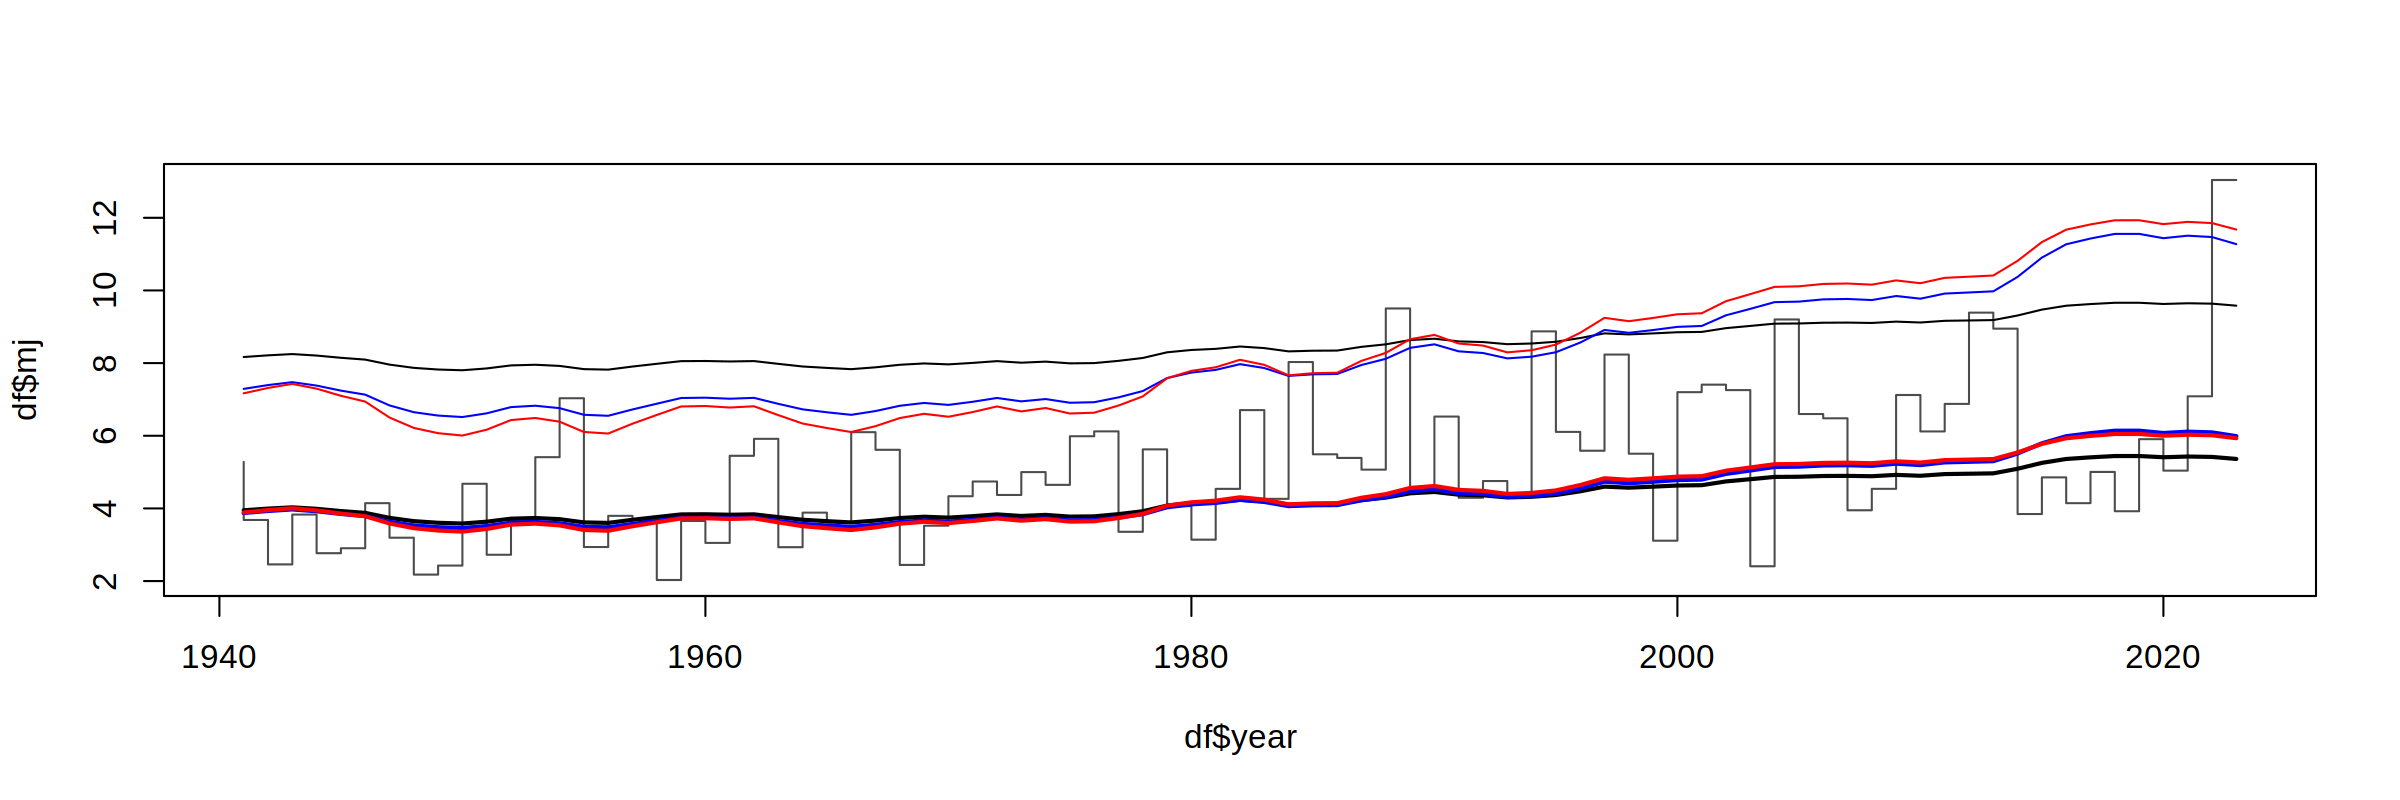

In [41]:
plot(df$year, df$mj, type = "S", col = adjustcolor("black", alpha = 0.7))

lines(df$year, ns_pars(mdl_shift)$loc, lwd = 2, col = "black")
lines(df$year, ns_pars(mdl_fixeddisp)$loc, lwd = 2, col = "blue")
lines(df$year, findpars(mdl_shiftscale)$location, lwd = 2, col = "red")

lines(df$year, eff_return_level(20, mdl_shift), col = "black")
lines(df$year, eff_return_level(20, mdl_fixeddisp), col = "blue")
lines(df$year, return.level(mdl_shiftscale, 20), col = "red")

# shift-only is very flat flat, there's still a trend in exceedances; similar mean trends in fixeddisp & shift+scale. Use fixeddisp.

### **Check trend in MJJA**

In [57]:
# compare trend excluding this year
mdl_mj_fixeddisp <- fit_ns("gev", "fixeddisp", df[df$year < 2023,], "mj", "gmst", lower = F)
mdl_mjja_fixeddisp <- fit_ns("gev", "fixeddisp", df[df$year < 2023,], "mjja", "gmst", lower = F)

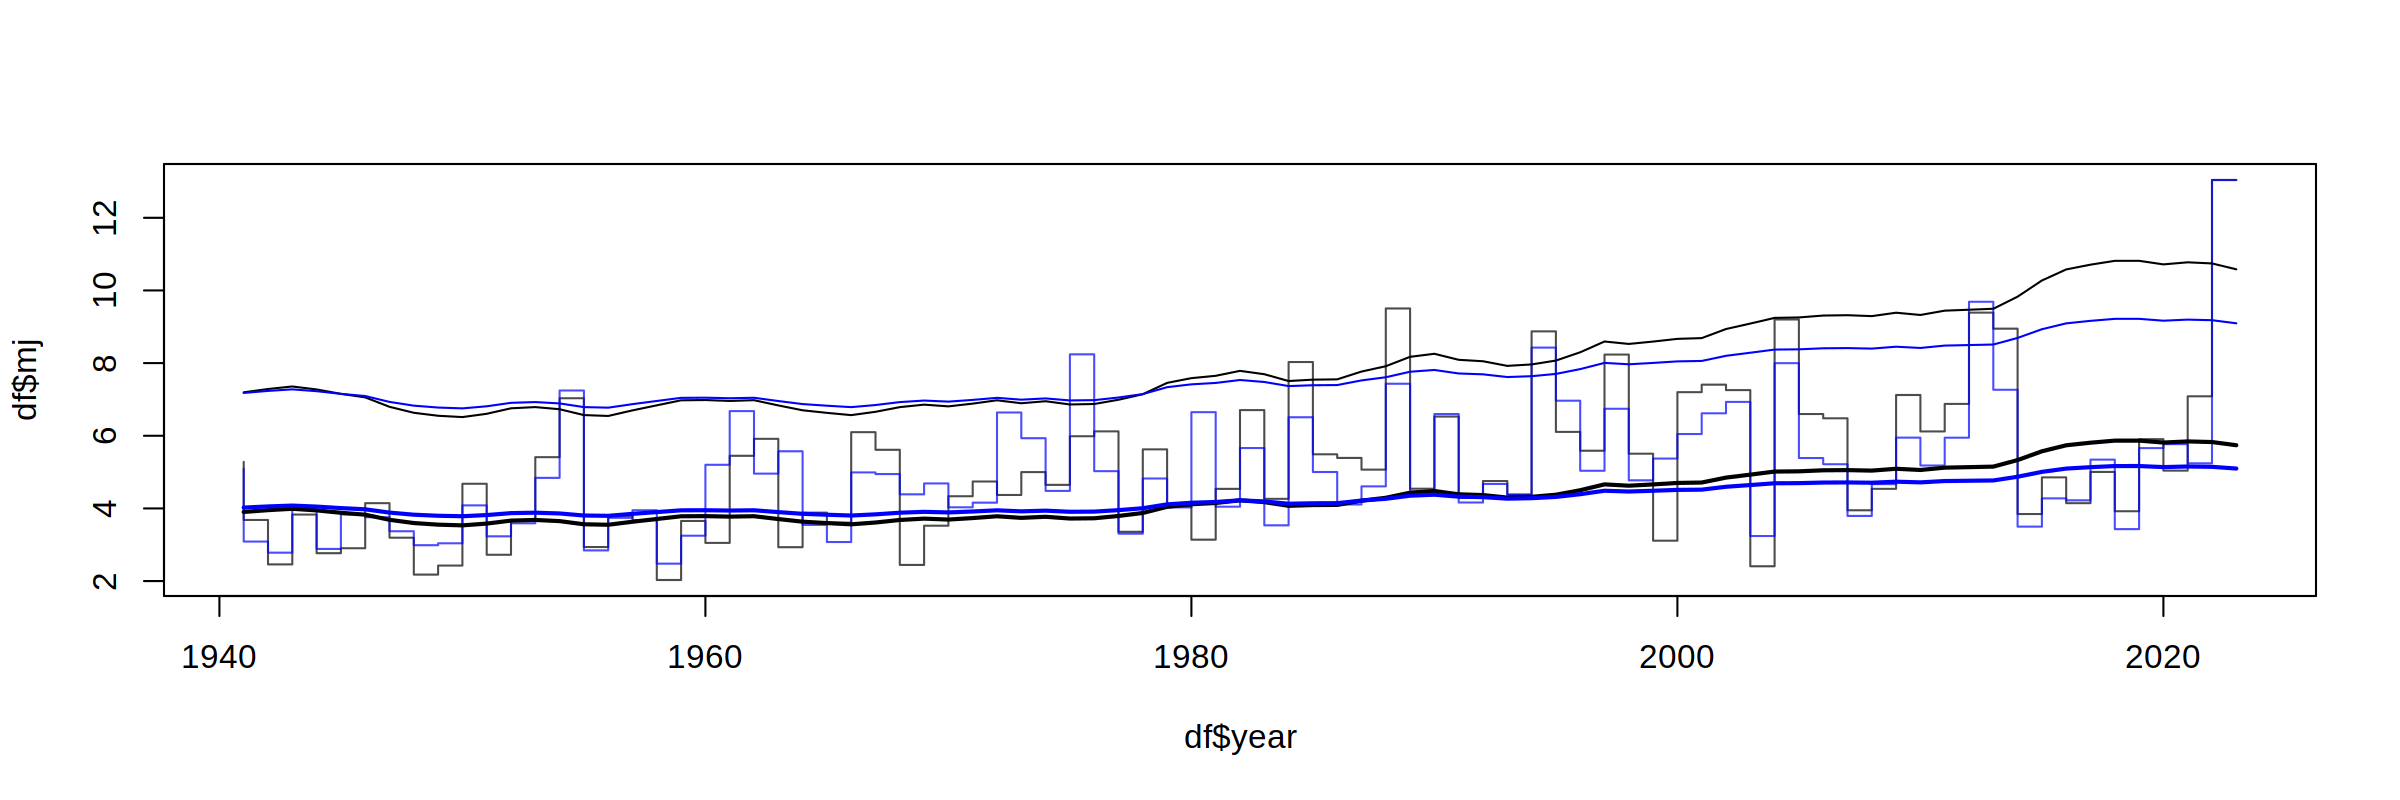

In [59]:
plot(df$year, df$mj, type = "S", col = adjustcolor("black", alpha = 0.7))
lines(df$year, df$mjja, type = "S", col = adjustcolor("blue", alpha = 0.7))

lines(df$year, ns_pars(mdl_mj_fixeddisp, fixed_cov = df$gmst)$loc, lwd = 2, col = "black")
lines(df$year, eff_return_level(20, mdl_mj_fixeddisp, fixed_cov = df$gmst), col = "black")

lines(df$year, ns_pars(mdl_mjja_fixeddisp, fixed_cov = df$gmst)$loc, lwd = 2, col = "blue")
lines(df$year, eff_return_level(20, mdl_mjja_fixeddisp, fixed_cov = df$gmst), col = "blue")

# slightly stronger trend in early-season extremes

---
## **N-day maximum of FWI (fwiNx)**

Area average of annual maximum of n-day rolling mean of FWI (taken over whole year)

### **Choose best statistical model**

In [145]:
df = merge(read.csv("data/gmst.csv"), read.csv("data/era5_fwiNx_annual.csv"))[,c("year", "gmst", "X7")]
gmst_2023 <- df$gmst[df$year == 2023]

mdl_shift <- fit_ns("gev", "shift", df, "X7", "gmst", lower = F)
mdl_fixeddisp <- fit_ns("gev", "fixeddisp", df, "X7", "gmst", lower = F)
mdl_shiftscale <- fevd(X7, df, location.fun = ~gmst, scale.fun = ~gmst)

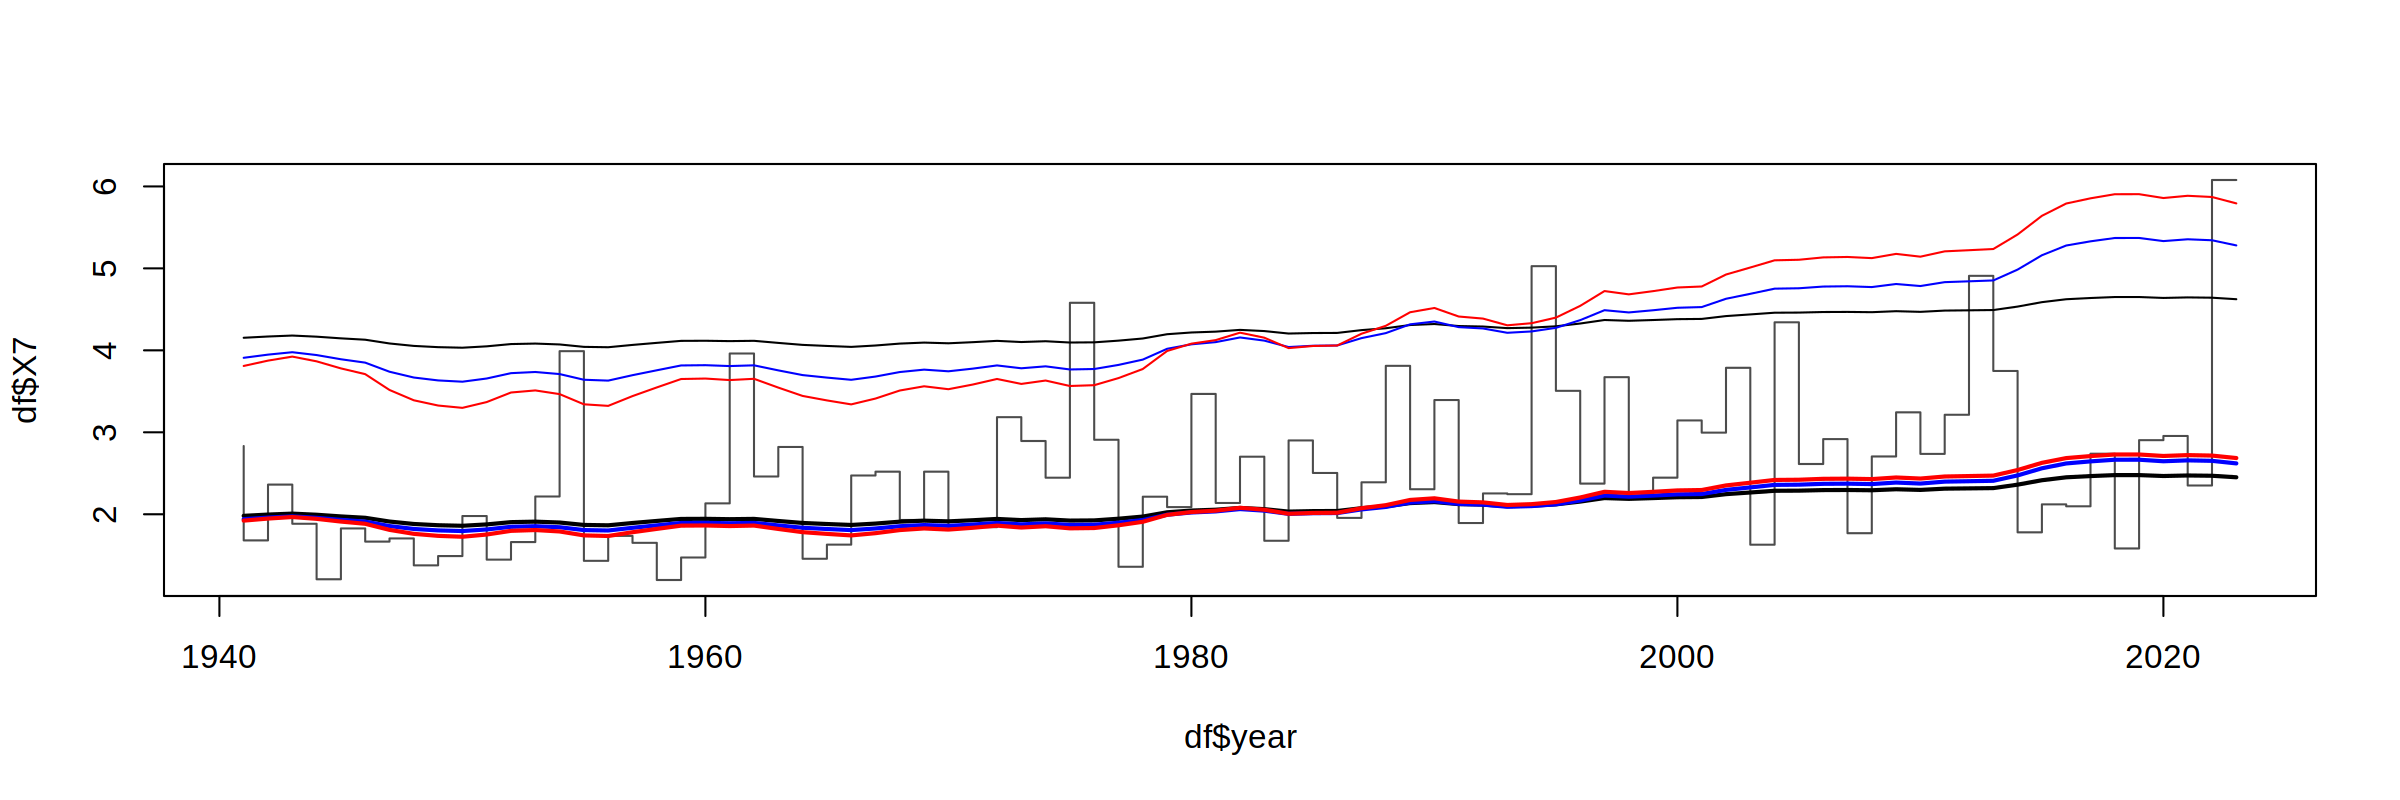

In [146]:
plot(df$year, df$X7, type = "S", col = adjustcolor("black", alpha = 0.7))

lines(df$year, ns_pars(mdl_shift)$loc, lwd = 2, col = "black")
lines(df$year, ns_pars(mdl_fixeddisp)$loc, lwd = 2, col = "blue")
lines(df$year, findpars(mdl_shiftscale)$location, lwd = 2, col = "red")

lines(df$year, eff_return_level(20, mdl_shift), col = "black")
lines(df$year, eff_return_level(20, mdl_fixeddisp), col = "blue")
lines(df$year, return.level(mdl_shiftscale, 20), col = "red")

In [187]:
qc_2023 = make.qcov(mdl_shiftscale, vals = list("mu1" = gmst_2023, "sigma1" = gmst_2023))
qc_pi = make.qcov(mdl_shiftscale, vals = list("mu1" = gmst_2023 - 1.2, "sigma1" = gmst_2023 - 1.2))

# change in intensity in each model
int_change(mdl_shift, rp = 20, gmst_2023, gmst_2023 - 1.2)
int_change(mdl_fixeddisp, rp = 20, gmst_2023, gmst_2023 - 1.2, relative = F)
return.level(mdl_shiftscale, return.period = 20, qcov = qc_2023, qcov.base = qc_pi)[1]

int_change(mdl_fixeddisp, rp = 20, gmst_2023, gmst_2023 - 1.2, relative = T)


[1] 0.7049265

[1] 1.915384

[1] 2.971933

[1] 56.92292

In [166]:
# return periods in each model
return_period(mdl_shift)[nrow(df)]
return_period(mdl_fixeddisp)[nrow(df)]
unname(1/(1-pextRemes(mdl_shiftscale, df$X7[df$year == 2023], qcov = qc_2023)))

[1] 91.82601

[1] 41.28565

[1] 24.96951

In [186]:
prob_ratio(mdl_shift, df$X7[df$year == 2023], gmst_2023, gmst_2023 - 1.2)
prob_ratio(mdl_fixeddisp, df$X7[df$year == 2023], gmst_2023, gmst_2023 - 1.2)
unname((1-pextRemes(mdl_shiftscale, df$X7[df$year == 2023], qcov = qc_2023)) / (1-pextRemes(mdl_shiftscale, df$X7[df$year == 2023], qcov = qc_pi)))

[1] 1.931644

[1] 14.31762

[1] 90.65825

In [114]:
# shift-only is clearly too flat, there's still a trend in exceedances; similar mean trends in fixeddisp & shift+scale but shiftscale has v high return level
# fixeddisp gives intermediate return level & PR. Since there is also a precedent, stick with fixeddisp.

### **Which timescale to consider?**

In [189]:
df = merge(read.csv("data/gmst.csv"), read.csv("data/era5_fwiNx_annual.csv"))
gmst_2023 <- df$gmst[df$year == 2023]

In [42]:
invisible(sapply(c(5,7,9,11,13,15), function(nd) {

    ylim <- c(0,8)

    mdl <- fit_ns("gev", "fixeddisp", df, paste0("X",nd), "gmst", lower = F)
    rp <- round(return_period(mdl, mdl$ev, fixed_cov = gmst_2023))
    pr <- round(prob_ratio(mdl, mdl$ev, gmst_2023, gmst_2023 - 1.2),1)

    prep_window(c(1,3))
    png(paste0("fig/event-def_mfit-fixeddisp_fwi",nd,"x.png"), height = 480, width = 480 * 3); par(mfrow = c(1,3), cex = 1.4); {
        par(oma = c(0,0,2.5,0))
        plot_trend(mdl, legend_pos = NA, ylim = ylim, main = "Estimated trend")
        plot_returnlevels(mdl, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, nsamp = 5, ylim = ylim, main = paste0("Return levels (rp ",rp,"; pr ",pr,")"))
        plot_gmsttrend(mdl, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, ylim = ylim, main = paste0("Estimated trend in GMST (", round(mdl$par["alpha"], 2), ")"))
        mtext(paste0("FWI",nd,"x: GEV, fixeddisp fit"), outer = T, line = 0, font = 2, cex = 1.6)
    }; dev.off()
    
}))

In [195]:
sapply(c(5,7,9,11,13,15), function(nd) {
    mdl <- fit_ns("gev", "fixeddisp", df, paste0("X",nd), "gmst", lower = F)
    mdl_ests(mdl, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ev = mdl$ev)
    })

# return period fairly stable
# stronger trend in shorter aggregation (presumably translates to stronger trend in more extreme values?)
# PR reasonably stable (10-15)
# relative change in intensity is stable (55-56%) - only the absolute trend changes

mu0,2.25499016,1.8734285,1.6206560,1.4358341,1.2986747,1.1906642
sigma0,0.62954307,0.5466263,0.4868050,0.4446727,0.4087958,0.3758475
alpha,0.84557168,0.7034482,0.5917664,0.5290515,0.4877049,0.4472388
shape,0.09427077,0.1037345,0.1146398,0.1269413,0.1335882,0.1414314
disp,0.27917775,0.2917786,0.3003753,0.3096964,0.3147792,0.3156621
event_magnitude,7.01199530,6.0784080,5.3667410,4.8346677,4.3882790,4.0372120
return_period,39.74542036,41.2856522,41.4035664,37.7831988,34.3509823,33.2499884
PR,16.23496080,14.3176209,11.7189055,10.4316803,10.1123390,9.4994794
dI_abs,2.54083162,2.2049087,1.9040265,1.7276698,1.5920029,1.4648904
dI_rel,56.82707700,56.9229164,54.9865271,55.6057582,56.9329678,56.9481837


In [200]:
boot_ci(fit_ns("gev", "fixeddisp", df, "X7", "gmst", lower = F), cov = gmst_2023, cov_cf = gmst_2023 - 1.2, ev = df$X7[df$year == 2023])

# range of alpha covers range from other n
# very wide range of return periods & PRs, all compatible with the best estimates from other n

,bestimate,2.5%,97.5%
mu0,1.87343,1.71122,2.06760
sigma0,0.54663,0.43084,0.64199
alpha,0.70345,0.30689,1.15560
shape,0.10373,-0.05726,0.27791
disp,0.29178,0.24073,0.32790
event_magnitude,6.07841,6.07841,6.07841
return_period,41.28565,15.46687,179.98921
PR,14.31762,2.56895,4766.09262
dI_abs,2.20491,1.04147,3.25112
dI_rel,56.92292,20.67725,114.99129


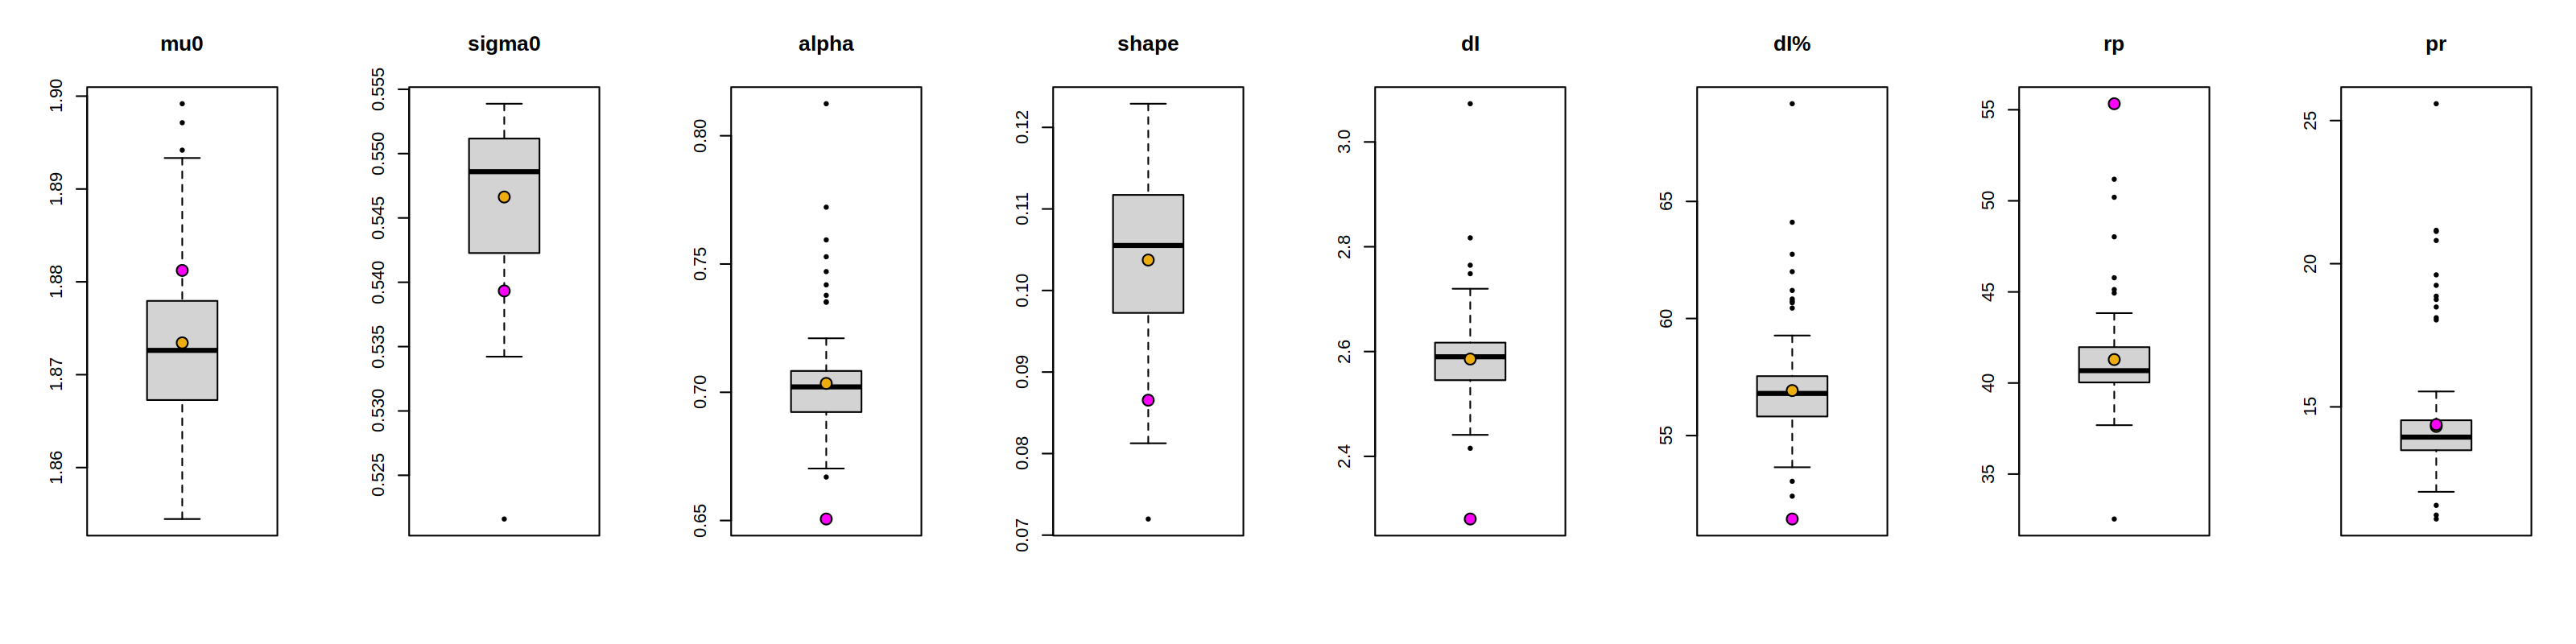

In [201]:
loo_pars(fit_ns("gev", "fixeddisp", df, "X7", "gmst", lower = F), cov = gmst_2023, cov_cf = gmst_2023 - 1.2)
# quite a lot of influence from the 2023 observation on strength of trend, less so on return period (difference between 40 & 55 is not large - also PR is fairly stable)

### **MJ or MJJA?**

In [248]:
df <- merge(read.csv("data/gmst.csv"), 
            merge(load_ts("ts/canada-wildfires_era5_fwi7x-mj.dat", col.names = c("year", "mj")),
                  load_ts("ts/canada-wildfires_era5_fwi7x-mjja.dat", col.names = c("year", "mjja"))))

In [250]:
mdl_mj <- fit_ns("gev", "fixeddisp", df, "mj", "gmst", lower = F)
mdl_mjja <- fit_ns("gev", "fixeddisp", df, "mjja", "gmst", lower = F)

In [258]:
invisible(sapply(c("mj", "mjja"), function(ts) {

    ylim <- c(0,8)

    mdl <- fit_ns("gev", "fixeddisp", df, ts, "gmst", lower = F)
    rp <- round(return_period(mdl, mdl$ev, fixed_cov = gmst_2023))
    pr <- round(prob_ratio(mdl, mdl$ev, gmst_2023, gmst_2023 - 1.2),1)

    prep_window(c(1,3))
    png(paste0("fig/event-def_mfit_fwi7x-",ts,".png"), height = 480, width = 480 * 3); par(mfrow = c(1,3), cex = 1.4); {
        par(oma = c(0,0,2.5,0))
        plot_trend(mdl, legend_pos = NA, ylim = ylim, main = "Estimated trend")
        plot_returnlevels(mdl, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, nsamp = 5, ylim = ylim, main = paste0("Return levels (rp ",rp,"; pr ",pr,")"))
        plot_gmsttrend(mdl, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, ylim = ylim, main = paste0("Estimated trend in GMST (", round(mdl$par["alpha"], 2), ")"))
        mtext(paste0("FWI7x ",ts,": GEV, fixeddisp fit"), outer = T, line = 0, font = 2, cex = 1.6)
    }; dev.off()
    
}))

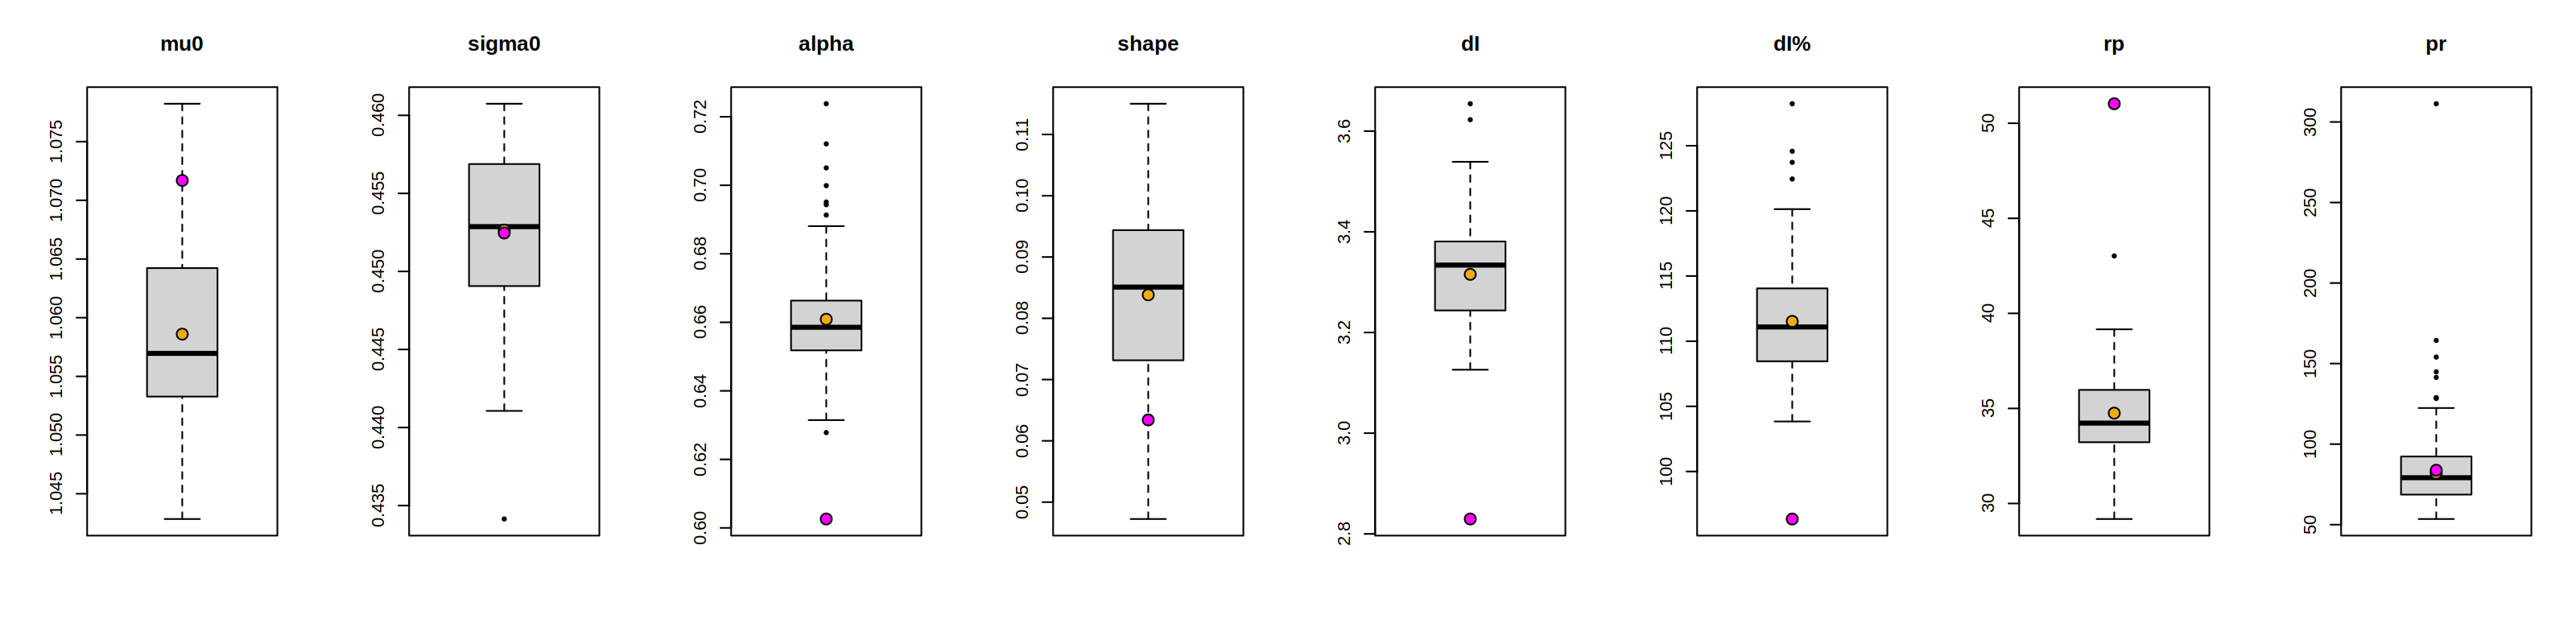

In [256]:
loo_pars(mdl_mj, cov = gmst_2023, cov_cf = gmst_2023 - 1.2)
# 2023 event has a lot of leverage - pushes RP up from 35 to 50, PR from 300 to 100

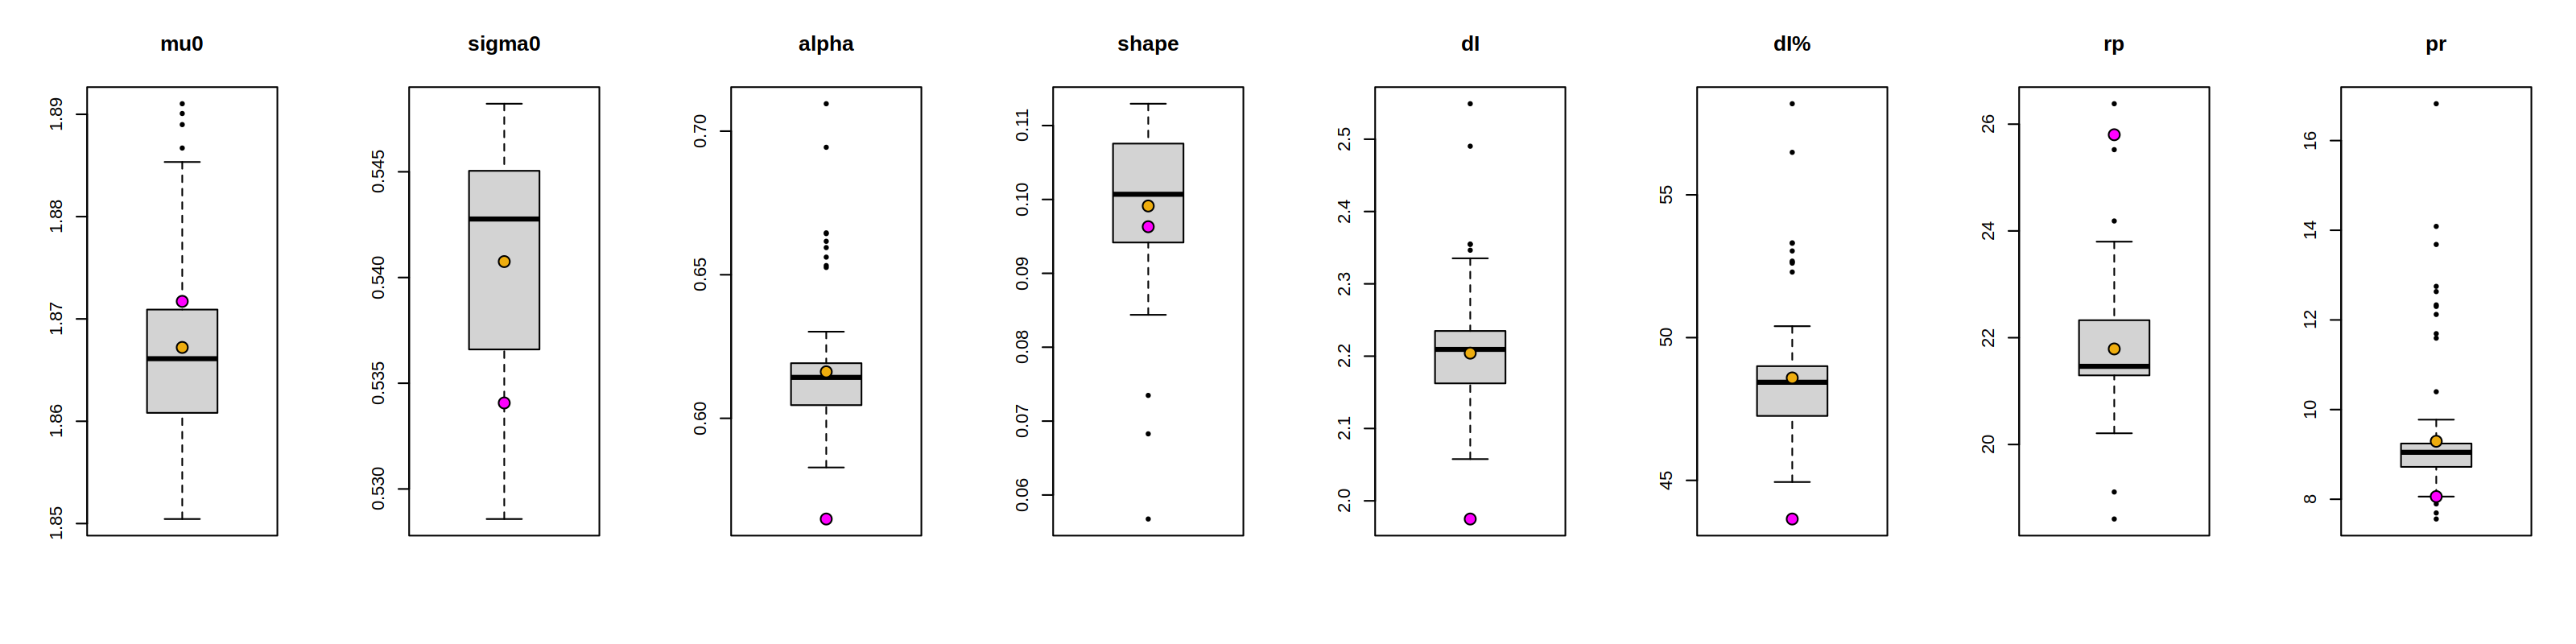

In [257]:
loo_pars(mdl_mjja, cov = gmst_2023, cov_cf = gmst_2023 - 1.2)
# more robust when using max over whole year (probably because this accounts for changing timing of season - use MJJA for all years prior to 2023)

---
## **Monthly severity rating (msr)**

In [301]:
df = merge(read.csv("data/gmst.csv"), read.csv("data/era5_severity-ratings.csv"))
gmst_2023 <- df$gmst[df$year == 2023]

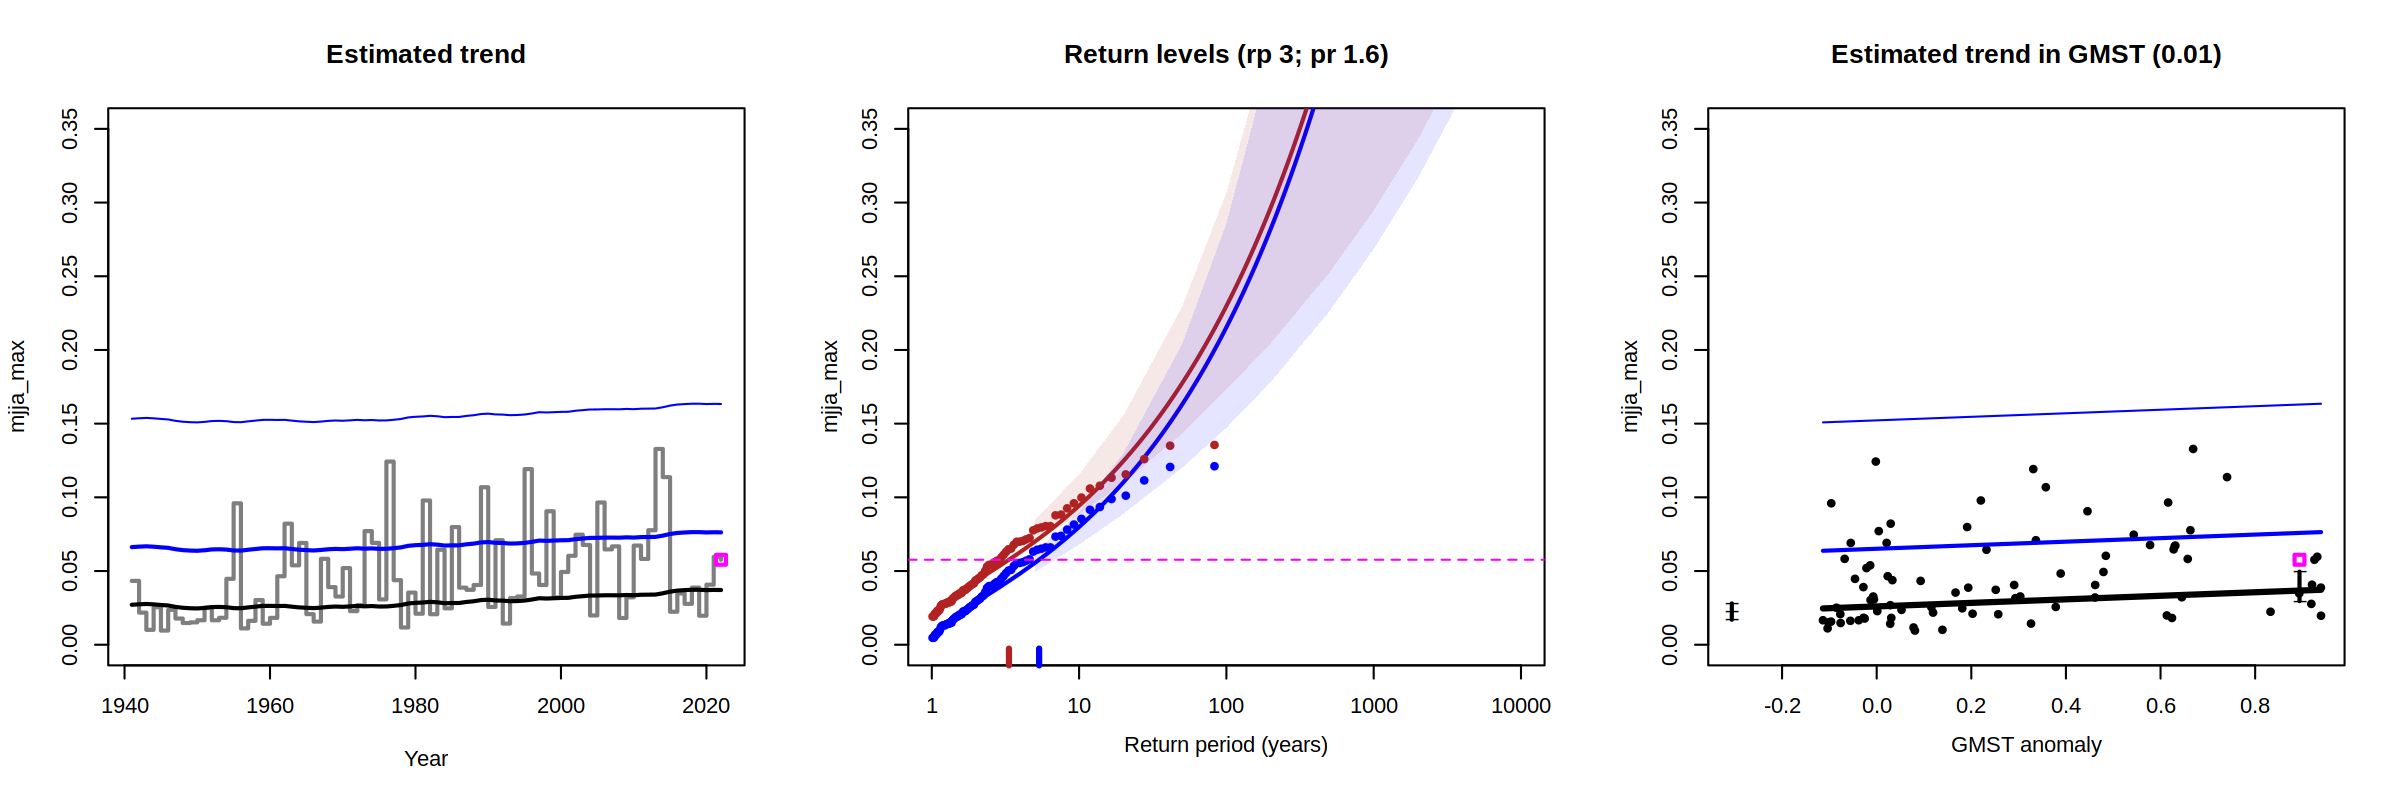

In [312]:
prep_window(c(1,3))
mdl <- fit_ns("gev", "shift", df[df$year < 2023,], "mjja_max", "gmst", lower = F)
rp <- round(return_period(mdl, mdl$ev, fixed_cov = gmst_2023))
pr <- round(prob_ratio(mdl, mdl$ev, gmst_2023, gmst_2023 - 1.2),1)
ylim <- c(0,.35)

plot_trend(mdl, legend_pos = NA, ylim = ylim, main = "Estimated trend")
plot_returnlevels(mdl, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, nsamp = 5, ylim = ylim, main = paste0("Return levels (rp ",rp,"; pr ",pr,")"))
plot_gmsttrend(mdl, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, ylim = ylim, main = paste0("Estimated trend in GMST (", round(mdl$par["alpha"], 2), ")"))

# haha NOPE

### **lognormal better fit?**

In [17]:
df = merge(read.csv("data/gmst.csv"), read.csv("data/era5_severity-ratings.csv"))
df$log10_mj_mean <- log10(df$mj_mean)

gmst_2023 <- df$gmst[df$year == 2023]

mdl <- fit_ns("norm", "shift", df, "log10_mj_mean", "gmst", lower = F)

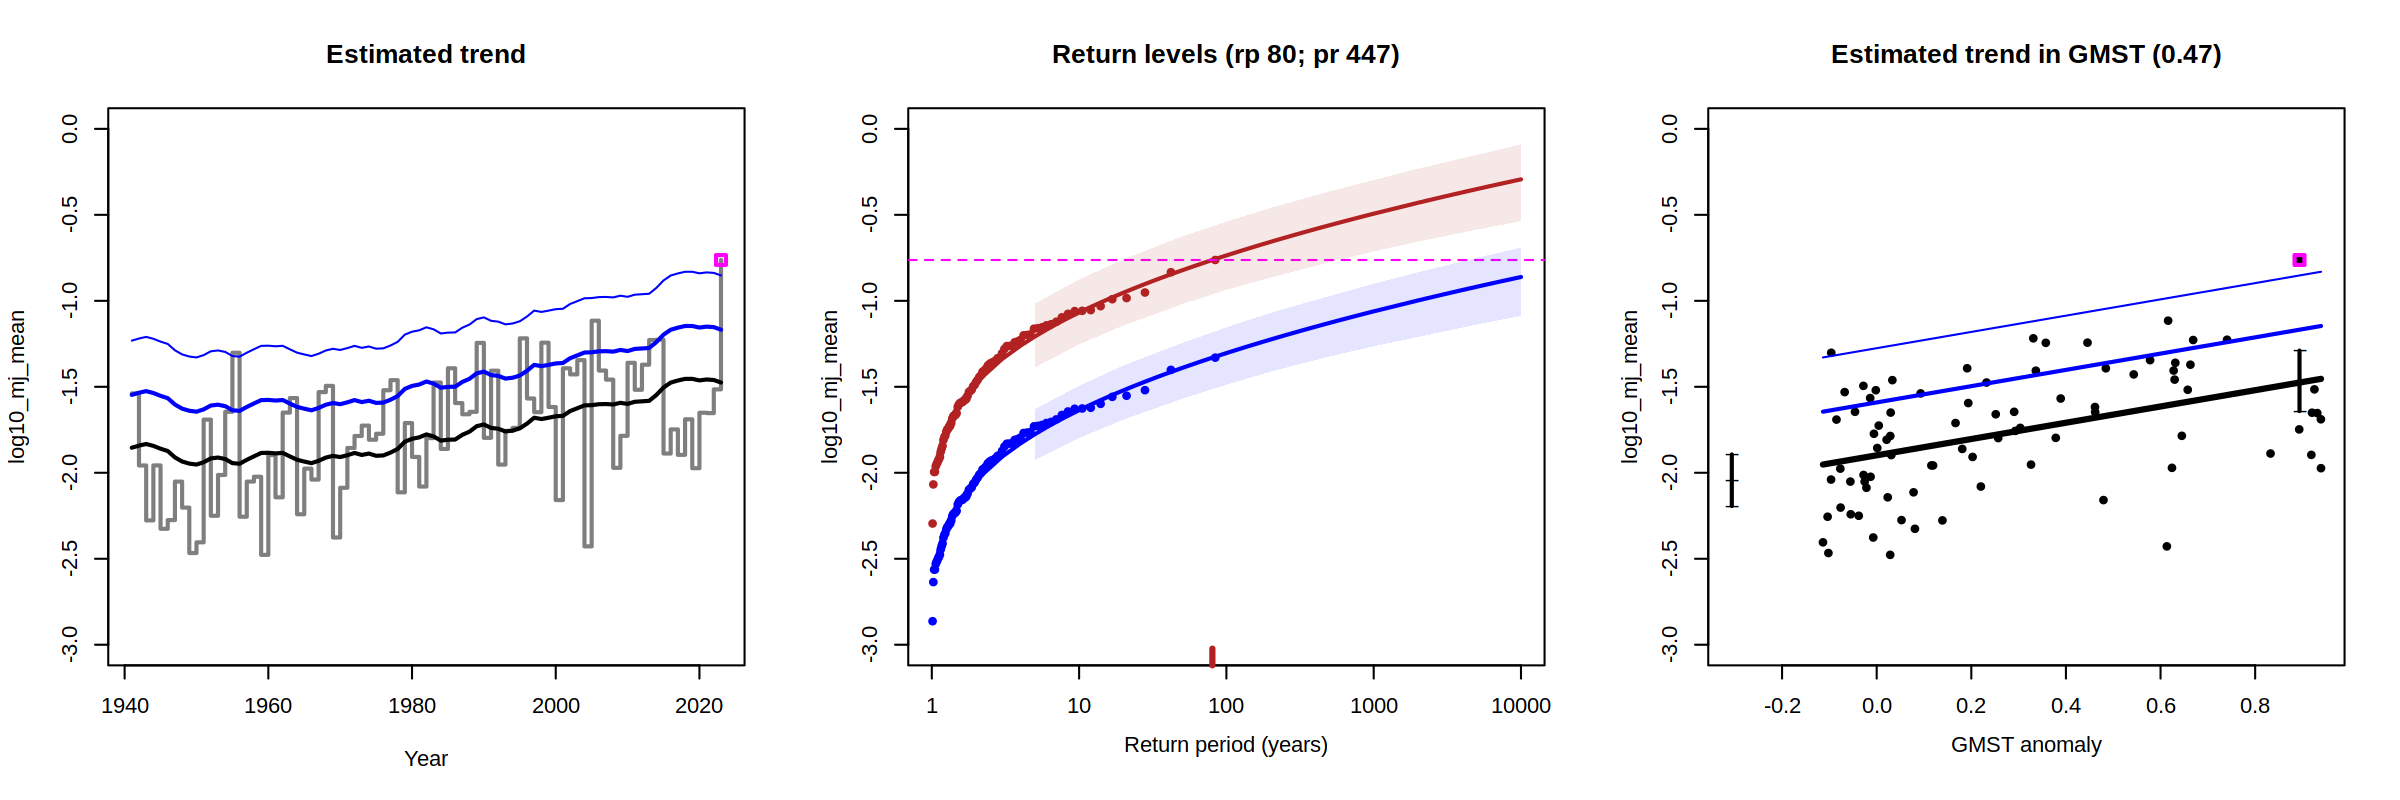

In [19]:
rp <- round(return_period(mdl, mdl$ev, fixed_cov = gmst_2023))
pr <- round(prob_ratio(mdl, mdl$ev, gmst_2023, gmst_2023 - 1.2),1)
ylim <- c(-3,0)

prep_window(c(1,3))
plot_trend(mdl, legend_pos = NA, main = "Estimated trend", ylim = ylim)
plot_returnlevels(mdl, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, nsamp = 500, ylim = ylim, main = paste0("Return levels (rp ",rp,"; pr ",pr,")"))
plot_gmsttrend(mdl, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, ylim = ylim, main = paste0("Estimated trend in GMST (", round(mdl$par["alpha"], 2), ")"))

### **Shift or scale?**

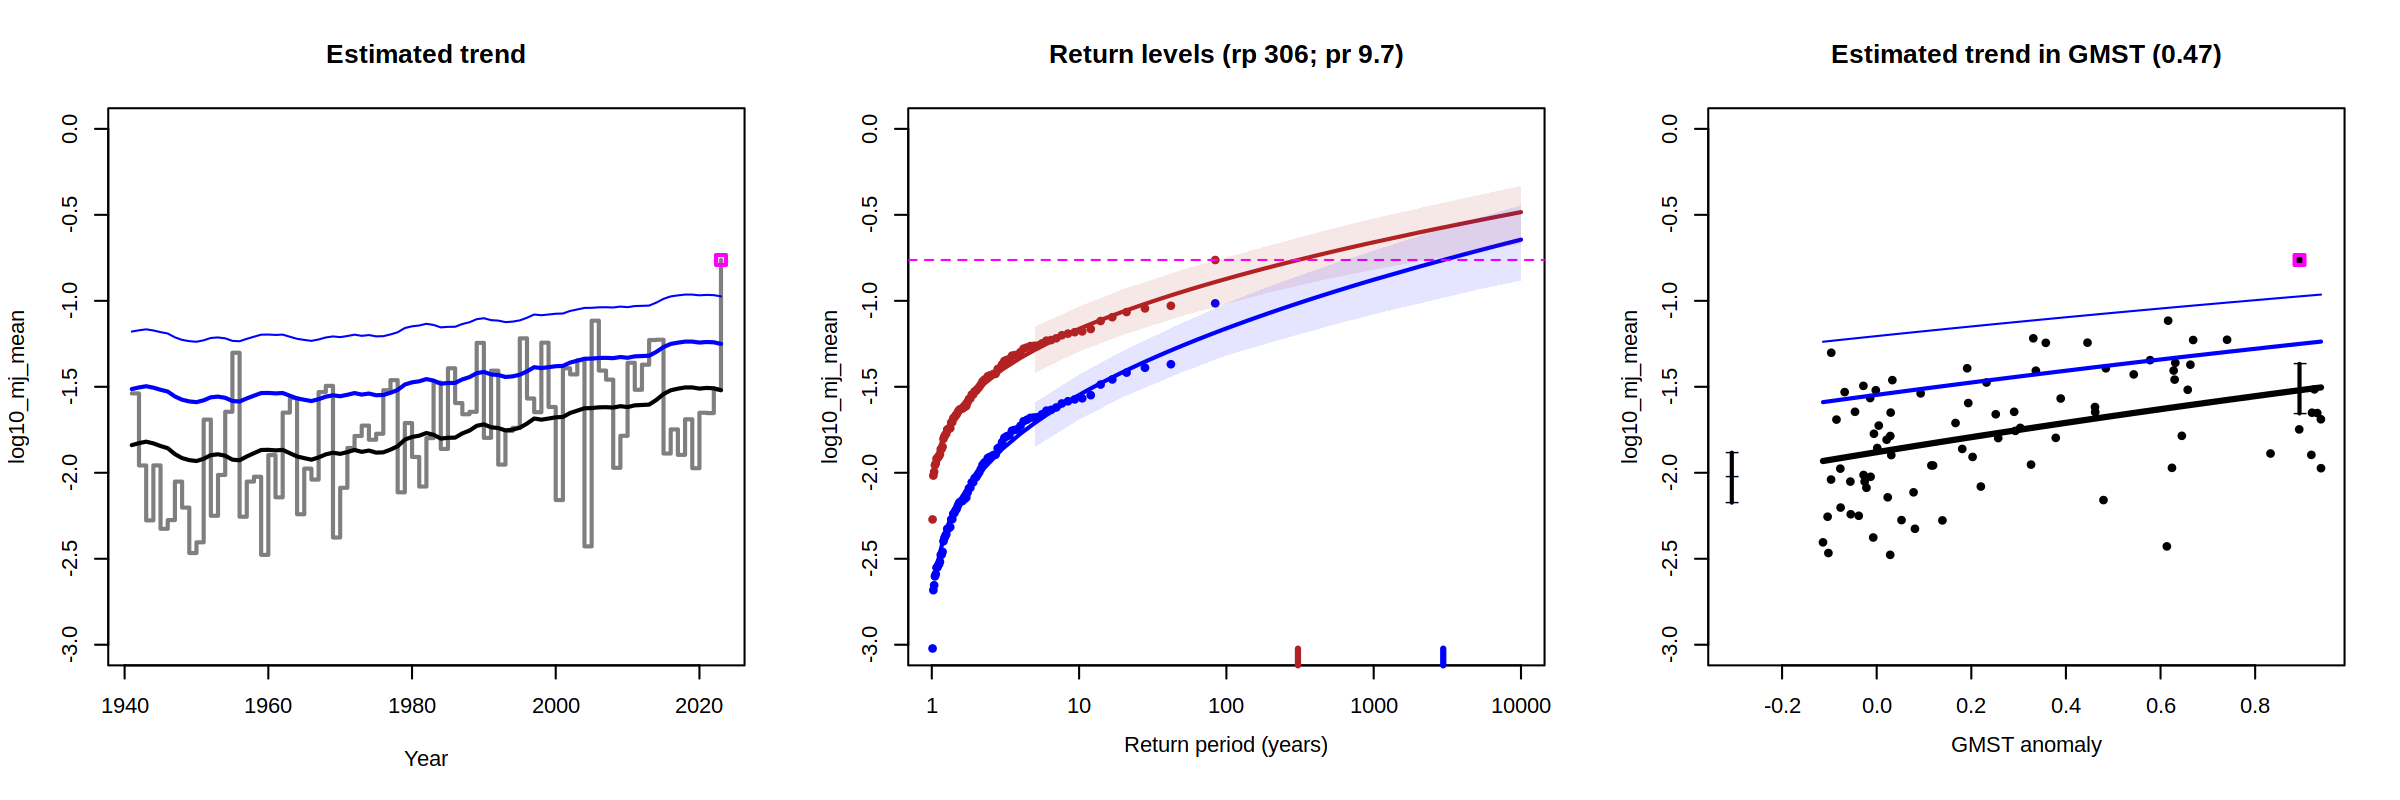

In [23]:
mdl_fd <- fit_ns("norm", "fixeddisp", df, "log10_mj_mean", "gmst", lower = F)

rp <- round(return_period(mdl_fd, mdl_fd$ev, fixed_cov = gmst_2023))
pr <- round(prob_ratio(mdl_fd, mdl_fd$ev, gmst_2023, gmst_2023 - 1.2),1)
ylim <- c(-3,0)

prep_window(c(1,3))
plot_trend(mdl_fd, legend_pos = NA, main = "Estimated trend", ylim = ylim)
plot_returnlevels(mdl_fd, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, nsamp = 500, ylim = ylim, main = paste0("Return levels (rp ",rp,"; pr ",pr,")"))
plot_gmsttrend(mdl_fd, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, ylim = ylim, main = paste0("Estimated trend in GMST (", round(mdl$par["alpha"], 2), ")"))

# definitely a worse fit from 'scale' version. In this case, stick with a shifted distribution. 
# Note that trend estimate is the same, but return period much higher in this model

### **Max/mean, MJ or MJJA?**


In [82]:
df = merge(read.csv("data/gmst.csv"), read.csv("data/era5_severity-ratings.csv"))

df$log10_mj_mean <- log10(df$mj_mean)
df$log10_mjja_mean <- log10(df$mjja_mean)
df$log10_mj_max <- log10(df$mj_max)
df$log10_mjja_max <- log10(df$mjja_max)

mdl_mjmean <- fit_ns("norm", "shift", df, "log10_mj_mean", "gmst", lower = F)
mdl_mjjamean <- fit_ns("norm", "shift", df, "log10_mjja_mean", "gmst", lower = F)
mdl_mjmax <- fit_ns("norm", "shift", df, "log10_mj_max", "gmst", lower = F)
mdl_mjjamax <- fit_ns("norm", "shift", df, "log10_mjja_max", "gmst", lower = F)

gmst_2023 <- df$gmst[df$year == 2023]

In [83]:
invisible(sapply(c("mj_mean", "mjja_mean", "mj_max", "mjja_max"), function(ts) {

    ylim <- c(-2.5,0)
    
    mdl <- fit_ns("norm", "shift", df, paste0("log10_", ts), "gmst", lower = F)

    rp <- round(return_period(mdl, mdl$ev, fixed_cov = gmst_2023))
    pr <- round(prob_ratio(mdl, mdl$ev, gmst_2023, gmst_2023 - 1.2),1)

    prep_window(c(1,3))
    png(paste0("fig/event-def_mfit_msr-log10",gsub("_","-",ts),".png"), height = 480, width = 480 * 3); par(mfrow = c(1,3), cex = 1.4); {
        par(oma = c(0,0,2.5,0))
        plot_trend(mdl, legend_pos = NA, ylim = ylim, main = "Estimated trend")
        plot_returnlevels(mdl, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, nsamp = 50, ylim = ylim, main = paste0("Return levels (rp ",rp,"; pr ",pr,")"))
        plot_gmsttrend(mdl, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, ylim = ylim, main = paste0("Estimated trend in GMST (", round(mdl$par["alpha"], 2), ")"))
        mtext(paste0("MSR log10 ",ts,": lognormal, shift fit"), outer = T, line = 0, font = 2, cex = 1.6)
    }; dev.off()
    
}))

---
## **Cumulative DSR**

In [13]:
df = merge(read.csv("data/gmst.csv"), load_ts("ts/canada-wildfires_era5_cumdsr-june.dat", col.names = c("year", "cumdsr")))
df$log10_cumdsr <- log10(df$cumdsr)

gmst_2023 <- df$gmst[df$year == 2023]

mdl <- fit_ns("norm", "shift", df, "log10_cumdsr", "gmst", lower = F)

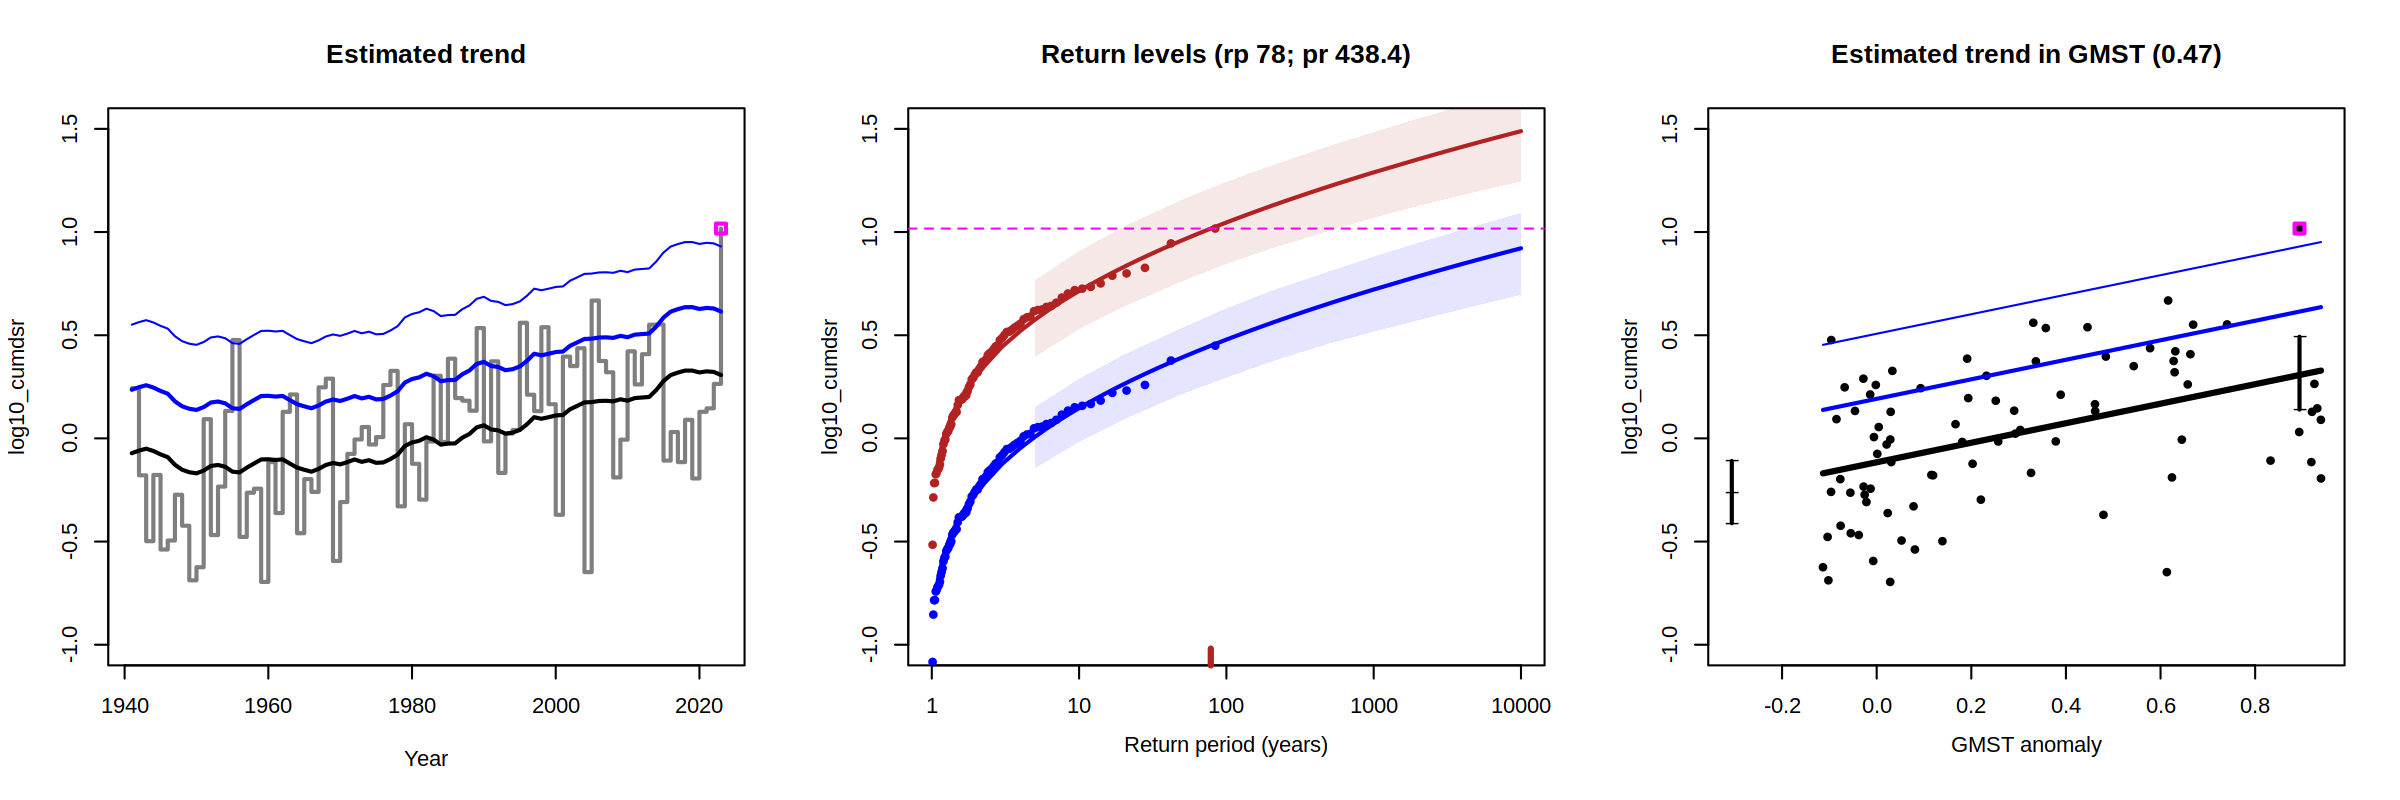

In [17]:
rp <- round(return_period(mdl, mdl$ev, fixed_cov = gmst_2023))
pr <- round(prob_ratio(mdl, mdl$ev, gmst_2023, gmst_2023 - 1.2),1)
ylim <- c(-1,1.5)

prep_window(c(1,3))
plot_trend(mdl, legend_pos = NA, main = "Estimated trend", ylim = ylim)
plot_returnlevels(mdl, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, nsamp = 500, ylim = ylim, main = paste0("Return levels (rp ",rp,"; pr ",pr,")"))
plot_gmsttrend(mdl, cov = gmst_2023, cov_cf = gmst_2023 - 1.2, legend_pos = NA, ylim = ylim, main = paste0("Estimated trend in GMST (", round(mdl$par["alpha"], 2), ")"))